![Banner](img/AI_Special_Program_Banner.jpg)

## Recurrent Neural Networks (RNN) - Material 3: Tiny Language Model (Character Level Training)
---

The material presented is adapted from *Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019 (code available on [GitHub](https://github.com/rasbt/python-machine-learning-book-3rd-edition)).

* Here: TLM (*Tiny* Language Model) instead of LLMs (Large Language Models) popularized by ChatGPT
* Many principles are the same, especially *randomness* (possibly leading to *hallucinations* with LLMs)
* Goal: generate text by "teaching" the computer a language by feeding it texts to learn from
* Approach: do this character-by-character (see [Sutskever et al.](https://icml.cc/2011/papers/524_icmlpaper.pdf))!
* Great read: [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

---

## Overview

- [Visualizing the idea](#Idea-visualized)
- [Preprocessing](#Preprocessing-the-dataset)
- [Classification Problem](#Problem-formulation-as-classification-task)
- [Building a character-level RNN model](#Building-a-character-level-RNN-model)
- [Evaluation phase: generating new text passages](#Preparing-the-evaluation-phase:-generating-new-text-passages)
- [Text generation](#Text-Generation)
- [Model Training](#Iterative-model-training)
- [Learning Outcomes](#Learning-Outcomes)

---

In [1]:
# ensure torchtext installed
try:
    import torchtext
except:
    print("Installing torchtext")
    !pip install torchtext   

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchtext
from torchtext.data import get_tokenizer
from torch import nn
from tqdm.notebook import trange, tqdm
# force gpu computing, when gpu library is available
USE_GPU = True

import datetime as dt

As we will see below, there is no ground truth here in the same sense as it occurs in other examples. Therefore, we need a special form of the training loop, since it does not make sense to calculate *validation accuracy* here.

In [3]:
# importing module for training loop
from train_loop import train_for_epochs_no_gt

In [4]:
#ignore warnings (use 'default' instead of 'ignore' if you want to see the warnings)
import warnings
warnings.filterwarnings('ignore')

In [5]:
CUDA_AVAILABLE = torch.cuda.is_available()
print(f'CUDA_AVAILABLE = {CUDA_AVAILABLE}')

CUDA_AVAILABLE = True


### Idea visualized
* break text down into sequence of characters
* then three step approach:
  - data preparation
  - build RNN model
  - sampling for generating new text

<img src="./img/16_11.png" width=700/>

### Preprocessing the dataset
* step 0: data (works by Mark Twain) obtained from [Project Gutenberg](https://www.gutenberg.org/)
* step 1: find list of *unique* characters

In [6]:
## Reading and processing text
with open('data/Twain.txt', 'r', encoding='utf8') as fp:
    text=fp.read()
    
start_idx = text.find('A CONNECTICUT YANKEE')
end_idx = text.find('END OF THIS PROJECT GUTENBERG EBOOK')
print(start_idx, end_idx)

text = text[start_idx:end_idx]
char_set = set(text)
print('Total Length:', len(text))
print('Unique Characters:', len(char_set))

91 5197033
Total Length: 5196942
Unique Characters: 106


* step 2: create mappings to encode and decode the text

<img src="./img/16_12.png" width=700/>

In [7]:
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)}
char_array = np.array(chars_sorted)

text_encoded = np.array(
    [char2int[ch] for ch in text],
    dtype=np.int32)

print('Text encoded shape: ', text_encoded.shape)

print(text[:15], '     == Encoding ==> ', text_encoded[:15])
print(text_encoded[15:21], ' == Reverse  ==> ', ''.join(char_array[text_encoded[15:21]]))

Text encoded shape:  (5196942,)
A CONNECTICUT Y      == Encoding ==>  [28  1 30 42 41 41 32 30 47 36 30 48 47  1 52]
[28 41 38 32 32  1]  == Reverse  ==>  ANKEE 


In [8]:
#transform to tensor
ds_text_encoded = torch.from_numpy(text_encoded)

for i in range(5):
    ex = ds_text_encoded[i]
    print(f'{ex.numpy()} -> {char_array[ex.numpy()]}')

28 -> A
1 ->  
30 -> C
42 -> O
41 -> N


### Problem formulation as classification task
---
* Given a sequence of text, we want to predict the next character
* $\rightarrow$ multiclass with number of classes $=$ number of unique characters
<img src="./img/16_13.png" width=700/>

+ $\rightarrow$ iterative generation of text
+ inputs and targets offset by one

<img src="./img/16_14.png" width=700/>

### Implementation in PyTorch
---
* decide on *length of sequence* to use for training
  + longer sequences $\rightarrow$ more meaningful sentences, but possibly harder to capture long-term dependencies
  + shorter sequences $\rightarrow$ correct on individual words, but ignoring context
* $\rightarrow$ hyperparameter to be optimized

In [9]:
class CharSequenceDataset(Dataset):

    def __init__(self, text_encoded, seq_length, offset):
        sequences = []
        target = []
        for i in range(0, len(text_encoded) - seq_length - 1, offset):
            seq = text_encoded[i: i + seq_length]
            sequences.append(seq)
            target.append(text_encoded[i + seq_length])
        self.sequences = torch.tensor(sequences)
        self.target = torch.tensor(target)
        
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.target[idx]
    

seq_length = 40
offset = seq_length 

ds = CharSequenceDataset(text_encoded, seq_length, offset)

## inspection:
for seq, target in ds:
    print(seq.numpy(), ' -> ', target.numpy())
    print(repr(''.join(char_array[seq])), 
          ' -> ', repr(''.join(char_array[target])))
    break

[28  1 30 42 41 41 32 30 47 36 30 48 47  1 52 28 41 38 32 32  1 36 41  1
 38 36 41 34  1 28 45 47 35 48 45  5 46  1 30 42]  ->  48
"A CONNECTICUT YANKEE IN KING ARTHUR'S CO"  ->  'U'


In [10]:
# final preparation step: create a data loader
BATCH_SIZE = 128

trainloader = DataLoader(ds, shuffle=True, batch_size=BATCH_SIZE)
len(ds)

129923

In [11]:
# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() and USE_GPU else "cpu")
print(f'Using {device} for training the network')

Using cuda for training the network


### Building a character-level RNN model
---
* no activation in the final FC layer $\rightarrow$ logits available for sampling later
* we will try out the GRU architecture this time
* bi-directionality is obviously not needed for this specific task

In [12]:
class Network(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_units, recurrent_type='LSTM'):
        super(Network, self).__init__()
        self.recurrent_type = recurrent_type
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if recurrent_type == 'RNN':
            self.rnn = nn.RNN(embedding_dim, rnn_units, batch_first=True)
        elif recurrent_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, rnn_units, batch_first=True)
        elif recurrent_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, rnn_units, batch_first=True)
        self.linear = nn.Linear(rnn_units, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        #lstm also returns the cell hidden state
        if self.recurrent_type == "LSTM":
            output, (hidden, cell_hidden) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)
        # take the last time step and predict the next character
        output = self.linear(hidden[-1])
        return output

vocab_size = len(char_array)
# Define hyperparameters
embedding_dim = vocab_size // 4
rnn_units = 512

# Instantiate the PyTorch model
model = Network(vocab_size, embedding_dim, rnn_units, recurrent_type='GRU')
# Move the model weights to the desired device
model.to(device)
model

Network(
  (embedding): Embedding(106, 26)
  (rnn): GRU(26, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=106, bias=True)
)

In [13]:
# for accumulating the loss values over the epochs
hist_cum = []
# counting the numbe rof epochs trained so far
total_epochs = 0

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

### Preparing the evaluation phase: generating new text passages
* can convert logits to probabilities via [softmax function](https://en.wikipedia.org/wiki/Softmax_function)
* conversion just *scaling by a constant* $\rightarrow$ logits can be used directly for choosing most probable character
* for generating new text: need *(random) sampling*: [torch.multinomial](https://pytorch.org/docs/stable/generated/torch.multinomial.html)

In [14]:
# example 1: equal probabilities
logits = torch.tensor([[1.0, 1.0, 1.0]])
print('Probabilities:', torch.softmax(logits, 1))

# Define the number of samples to draw
num_samples = 10

# Use torch.multinomial to sample from the distribution
samples = torch.multinomial(torch.exp(logits), num_samples, replacement=True)
print(samples)

Probabilities: tensor([[0.3333, 0.3333, 0.3333]])
tensor([[1, 2, 1, 1, 1, 0, 1, 0, 1, 1]])


In [15]:
# example 2: higher probability for sample 2
logits = torch.tensor([[1.0, 1.0, 3.0]])
print('Probabilities:', torch.softmax(logits, 1))

# Define the number of samples to draw
num_samples = 10

# Use torch.multinomial to sample from the distribution
samples = torch.multinomial(torch.exp(logits), num_samples, replacement=True)
print(samples)

Probabilities: tensor([[0.1065, 0.1065, 0.7870]])
tensor([[1, 2, 2, 2, 2, 2, 0, 2, 2, 0]])


In [16]:
import torch

def sample(model, starting_str, 
           len_generated_text=500, 
           max_input_length=40,
           scale_factor=1.0):
    model.eval()
    
    encoded_input = [char2int[s] for s in starting_str]
    encoded_input = torch.tensor(encoded_input).view(1, -1).to(device)

    generated_str = starting_str
    
    with torch.no_grad():
        for i in range(len_generated_text):
            logits = model(encoded_input)
            logits = logits.squeeze(0)

            scaled_logits = logits * scale_factor
            new_char_idx = torch.multinomial(torch.exp(scaled_logits), num_samples=1)

            new_char_idx = new_char_idx[-1].item()

            generated_str += str(char_array[new_char_idx])

            new_char_idx = torch.tensor([new_char_idx]).view(1, 1).to(device)
            encoded_input = torch.cat(
                [encoded_input, new_char_idx],
                dim=1)
            encoded_input = encoded_input[:, -max_input_length:]

    return generated_str
# print(sample(model, starting_str="Huck didn't think"))

#### Temperature: Predictability vs. randomness
* scaling of logits before computing softmax possible
* scaling factor $\alpha$ can be interpreted as *inverse temperature* in physics
  + $\alpha > 1$: getting cooler $\rightarrow$ more predictable (distribution becomes more distinct)
  + $\alpha > 1$: getting warmer $\rightarrow$ more random (distribution becomes more uniform)
* tradeoff between sensibility and uniqueness of generated sample

In [17]:
# example
logits = torch.tensor([[1.0, 1.0, 3.0]])

print('Probabilities before scaling:        ', torch.softmax(logits, 1))
print('Probabilities after scaling with 1.5:', torch.softmax(1.5 * logits, 1))
print('Probabilities after scaling with 0.1:', torch.softmax(0.1 * logits, 1))

Probabilities before scaling:         tensor([[0.1065, 0.1065, 0.7870]])
Probabilities after scaling with 1.5: tensor([[0.0453, 0.0453, 0.9094]])
Probabilities after scaling with 0.1: tensor([[0.3104, 0.3104, 0.3792]])


**Generating samples of different characteristics**

Choose the (inverse) temperature value (`scale_factor`) as follows:
* $\approx 2.0$ for predictable results
* $\approx 0.5$ for highly random results
* $\approx 1.5$ for reasonable results

Obviously, this only holds once the model has reached a certain maturity, i.e., it has been trained for a reasonable amount of epochs. However, we can use the `sample` function to get a better idea as to how the model learns. We can even check what happens, if we apply the the model right after initialization.

### Text generation
This can be performed after various stages of training (just re-run the cell below after performing training). It is particularly interesting to do so right after initialization of the model and compare that to the output after just one epoch. What do you notice? Also, try continuing the training for some more epochs and see what happens then. Finally, play around with the (inverse) temperature a bit (values to try out could be $2.0, 1.5$ and $0.5$, e.g.

In [21]:
inverse_temperature = 2.
temp_cat = "Low temperature"
if inverse_temperature <= 1.5001:
    if inverse_temperature <= 0.8001:
        temp_cat = "High temperature"
    else:
        temp_cat = "Normal temperature"

print(f'Performing sampling after {total_epochs} epochs of training with (inverse) temperature set to {inverse_temperature:.1f}')
print(f"\n{temp_cat}:\n========================")
print(sample(model, starting_str="Huck didn't think", 
             scale_factor=inverse_temperature))

Performing sampling after 1 epochs of training with (inverse) temperature set to 2.0

Low temperature:
Huck didn't think the manted their not we the had cansers, and here were not got of heid with the rearsing
the stood the stand the proses proce menty the was good of the with dever lafsed the masterss, and here were was the some of
coneresteres and mand the crooded of the was be pernessing the shother the hald not the king
court king the was the prowed then as they was no the there and lith
the precter he the geat in the keve worked hive never of the wanthers the seet of the is got like a forsterts and here from


### Iterative model training

Now perform the training loop once and go back to check what output the model produces then. Afterwards, continue training and go back and forth between sampling and training to get a feeling for the progress the model makes towards a TML.

In [19]:
NUM_EPOCHS = 1 
# run training
start_train = dt.datetime.now()
print(f'Charlevel training started: {start_train}')
history = train_for_epochs_no_gt(device, NUM_EPOCHS, model, trainloader, optimizer, criterion)
finish_train = dt.datetime.now()
print(f'Charlevel training finished {finish_train} (duration: {finish_train - start_train})')
#accumulate loss values
hist_cum += history['loss']
total_epochs += NUM_EPOCHS

Charlevel training started: 2024-01-28 23:24:44.114913


  0%|          | 0/1 [00:00<?, ?it/s]

Charlevel training finished 2024-01-28 23:24:53.853363 (duration: 0:00:09.738450)


### Checking the loss curve
Finally, we can plot the loss curve to get a feeling as to whether the model is still improving

The model has been trained for 1 epochs so far



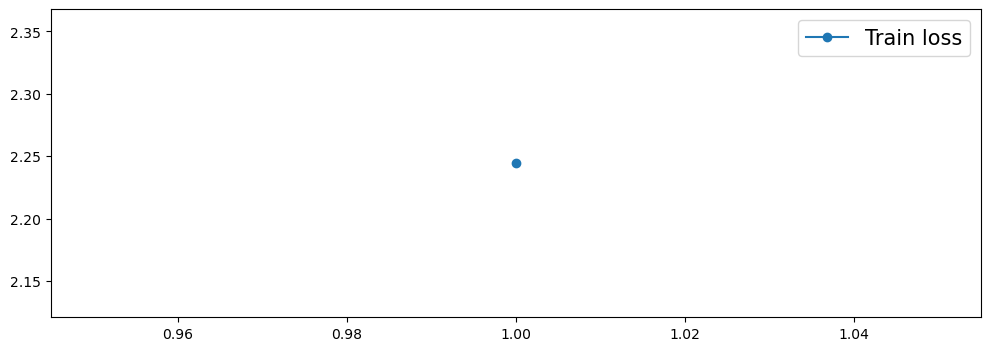

In [20]:
print(f'The model has been trained for {total_epochs} epochs so far\n')
# plot the loss curve
x_arr = np.arange(len(hist_cum)) + 1

fig = plt.figure(figsize=(12, 4))
plt.plot(x_arr, hist_cum, '-o', label='Train loss')
plt.legend(fontsize=15)

plt.show()

## Learning Outcomes
---
With the conclusion of the chapter on RNNs, you should now

* know the differences between sequential and non-sequential data;
* have an idea in which areas of application RNNs are a suitable machine learning technique;
* have a solid understanding of the key concepts that differentiate RNNs from other network architectures;
* have the ability to describe an LSTM cell and what issues it overcomes;
* be comfortable with a variety of NLP-related data preprocessing techniques, such as tokenization, encoding, and embeddings;
* be able to perform sentiment analysis utilizing RNNs;
* train a model to generate text in the style of works presented a learning material;
* have the ability to implement RNNs on your own, with the help of `PyTorch`.